<a href="https://colab.research.google.com/github/BhekiMabheka/Competitions/blob/master/Spot_A_Mask_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Spot the Mask Challenge

### Description

Face masks have become a common public sight in the last few months. The Centers for Disease Control (CDC) recently advised the use of simple cloth face coverings to slow the spread of the virus and help people who may have the virus and do not know it from transmitting it to others. Wearing masks is broadly recognised as critical to reducing community transmission and limiting touching of the face.

In a time of concern about slowing the transmission of COVID-19, increased surveillance combined with AI solutions can improve monitoring and reduce the human effort needed to limit the spread of this disease. The objective of this challenge is to create an image classification machine learning model to accurately predict the likelihood that an image contains a person wearing a face mask, or not. The total dataset contains 1,800+ images of people either wearing masks or not.

Your machine learning solution will help policymakers, law enforcement, hospitals, and even commercial businesses ensure that masks are being worn appropriately in public. These solutions can help in the battle to reduce community transmission of COVID-19.

### Evaluation
The evaluation metric for this challenge is [Area Under the Curve.](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

In [3]:
!pip install -Uqq fastai
!pip install -Uqq fastbook

In [4]:
from google.colab import drive

import torch
import os
import shutil
import random
from pathlib import Path
import pandas as pd
from sklearn.metrics import roc_auc_score

from fastai.vision.widgets import ImageClassifierCleaner
from fastai.vision.all import *

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#!unzip '/content/drive/MyDrive/Colab Notebooks/mask_challenge/spot_mask_challenge.zip' > /dev/null;

In [7]:
def get_items(path):
    return get_image_files(path)

# Function to get labels from image paths
def get_y(file_path):
    label = df[df['image'] == file_path.name]['target'].values[0]
    return label
    #return "with_no_mask" if label == 0 else "with_a_mask"

# Specify paths
csv_file_path = '/content/drive/MyDrive/Colab Notebooks/mask_challenge/train_labels (1).csv'
image_folder = '/content/images'
save_folder = '/content/drive/MyDrive/Colab Notebooks/mask_challenge/saved_images'

# Read CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Create a DataBlock
mask_data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_items,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(460),
    batch_tfms=[*aug_transforms(size=224), Normalize.from_stats(*imagenet_stats)]
)

# Create a DataLoader
dls = mask_data.dataloaders(save_folder, bs=64)

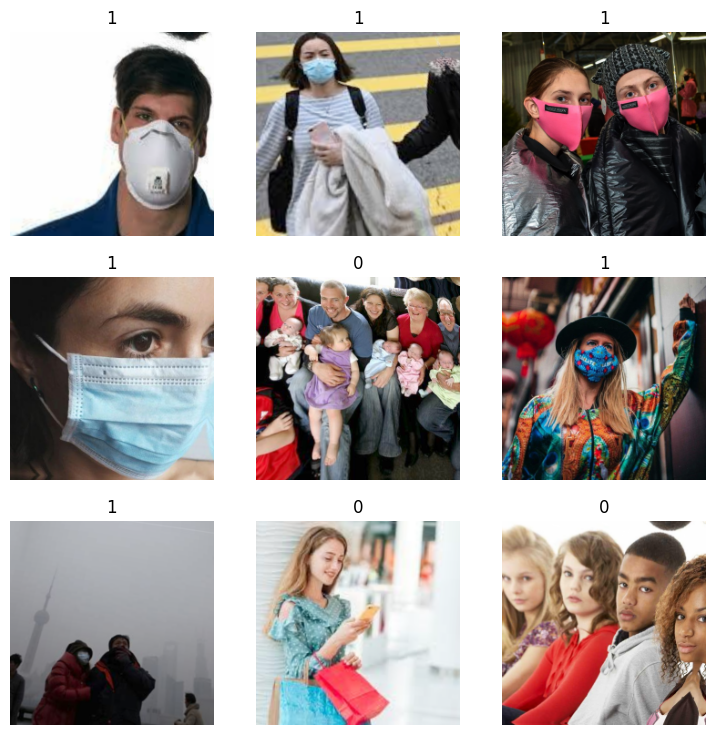

In [8]:
# Show a batch
dls.show_batch()


## Training the Model

We make use of Transfer Learning (using an existing, state-of-the-art, trained model) on our dataset. Here, we make use of the resnet50 model architecture which has been trained on the ImageNet dataset.


In [9]:
# Create a custom AUC metric function
def auc_metric(preds, targets):
    # Move predictions and targets to CPU and convert to NumPy arrays
    preds_np = preds[:, 1].detach().cpu().numpy()
    targets_np = targets.cpu().numpy()

    return roc_auc_score(targets_np, preds_np)

# Create a vision learner
learn = vision_learner(dls, resnet50, metrics=[auc_metric]).to_fp16()
learn.fit_one_cycle(10)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 124MB/s]


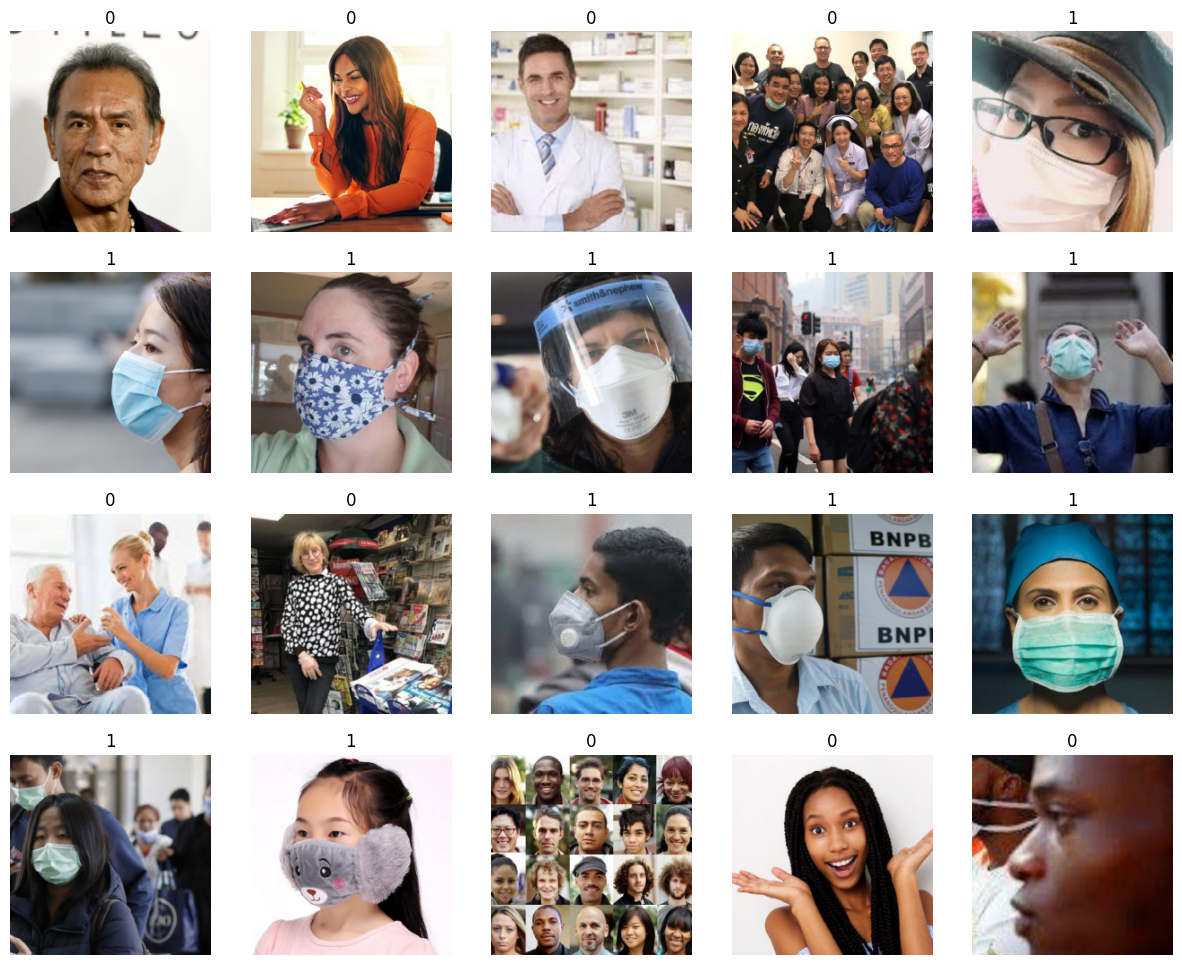

In [11]:
 dls.valid.show_batch(max_n=20, nrows = 4)

In [12]:
# Create a training DataLoader
train_dls = mask_data.dataloaders(save_folder, bs=64)

# Make predictions on the training set
train_predictions, _ = learn.get_preds(dl=train_dls[0])

# Extract image filenames from the training DataLoader
train_filenames = [f.name for f in train_dls[0].items]

In [13]:
# Convert predictions to labels (assuming binary classification)
predicted_labels_train = [int(pred[1] > 0.5) for pred in train_predictions]

In [15]:
# Create a DataFrame for submission
submission_train_df = pd.DataFrame({'filename': train_filenames,
                                    'target': predicted_labels_train})

# Save the DataFrame to a CSV file
submission_train_df.to_csv('/content/submission_train.csv', index=False)

submission_train_df

filename  target
0     gzgiwpkzpxvezrswkevtepwikkkleq.jpg       0
1     qmnjdtxpccsokmtoxckorwgzxxsgew.jpg       0
2     zypzolrfxrwpsnredtykrepzarfyic.jpg       0
3     getiewdijstnrhqdfbogfcwalvcmen.jpg       0
4     susniwghkxvtakeqtoqgzqcrtbvayv.jpg       1
...                                  ...     ...
1042  kfonflqwzjoypdteyfienebvkryoyx.jpg       1
1043  zrgfntovqjzmrenvndkyfqskmhoqbo.jpg       1
1044  zzkykwuddhweeowmgfkmfzrbeoqylp.jpg       1
1045  ozfxfueqfdwzhryxxflxjdvqmkhwqd.jpg       0
1046  gviiddyxzzxeahhufylmqigymemiar.jpg       0

[1047 rows x 2 columns]

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

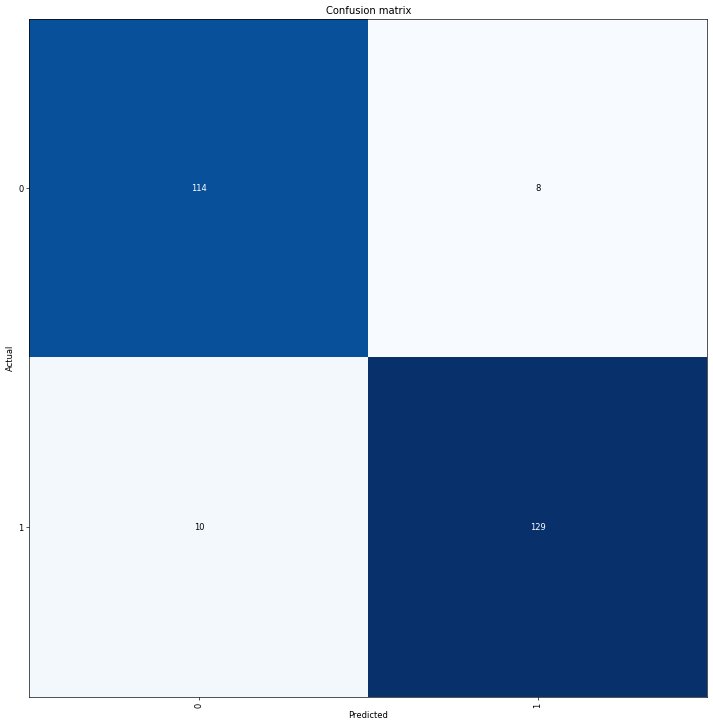

In [17]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

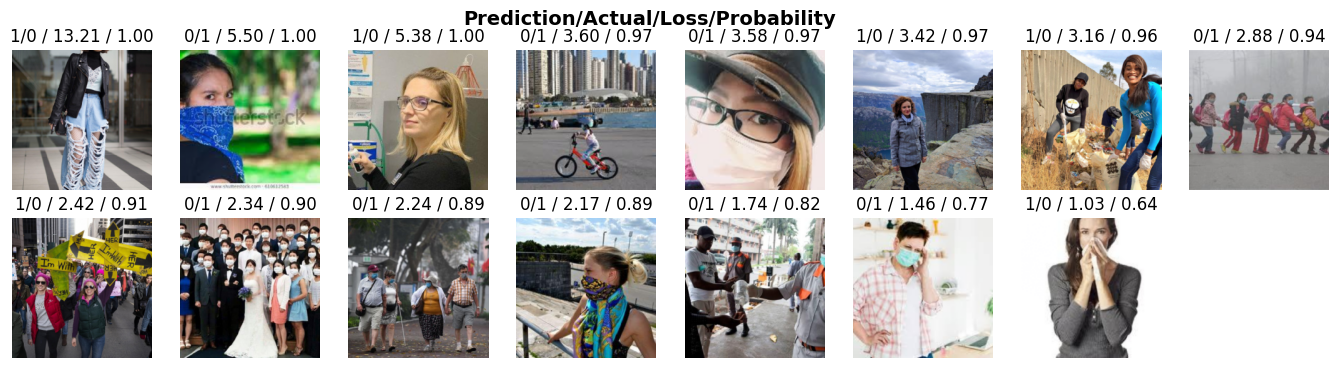

In [18]:
interp.plot_top_losses(15, nrows=2, figsize=(17, 4))

In [19]:
cleaner = ImageClassifierCleaner(learn)
cleaner